# TP53 benchmarking with JAPANESE BIOBANK CH DATA

#### Data from: Saiki et al 2021, Nat Med, Combined landscape of single-nucleotide variants and copy number alterations in clonal hematopoiesis https://www.nature.com/articles/s41591-021-01411-9

#### TP53 experimental assay from Ursu O, Neal JT, Shea E, Thakore PI, Jerby-Arnon L, Nguyen L, et al. Massively parallel phenotyping of coding variants in cancer with Perturb-seq. Nat Biotechnol 2022;40:896–905.

### 1. Get and arrange data
### 2. Create positive set
### 3. Create negative set
### 4. Evaluation BoostDM vs Experimental assay

In [1]:
import pandas as pd
import numpy as np
import os
from io import StringIO
import copy
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 30)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
from matplotlib import rcParams

In [2]:
TP53_Ursu = pd.read_csv('../../../Paper_data/Experimental_data/TP53/bench_TP53_Ursu.csv', sep='\t')
# Remove last two rows
TP53_Ursu = TP53_Ursu.iloc[:-2,:]
# Remove unavailable cases
TP53_Ursu = TP53_Ursu[~(TP53_Ursu['HotellingT2'].isna())]
TP53_Ursu

,Variant,Gene,Position: base(s),From ORF base(s),To ORF base(s),Position: amino acid(s),From amino acid(s),To amino acid(s),From ORF codon(s),To ORF codon(s),Mutation type,Control status,Variant barcode,Library synthesis,Cells/variant,Normalized variant barcode counts (TP10K),HotellingT2,HotellingT2.q,Variant functional class,Count (pancan),Count (ExAC),Count (IARC),"Nutlin-3, TP53 WT growth (z-score)","Nutlin-3, TP53 null growth (z-score)","Etoposide, TP53 null growth (z-score)",Insert sequence
0,R175H,TP53,524,G,A,175.0,R,H,CGC,CAC,Single,unknown,CCTACCAGGAAGAA,in,1001.0,2.103363,365.212625,0.000010,Impactful II,993.0,NaN,1221.0,1.791388,0.538396,-0.744765,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
1,R273C,TP53,817,C,T,273.0,R,C,CGT,TGT,Single,unknown,TCACAAGGCAAGAA,in,1253.0,1.983869,241.672937,0.000010,Impactful I,677.0,NaN,718.0,1.261347,0.314304,-0.930398,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
3,R273H,TP53,818,G,A,273.0,R,H,CGT,CAT,Single,unknown,CACTGAGGCAAGAA,in,835.0,1.820028,169.301582,0.000010,Impactful I,622.0,NaN,863.0,1.145501,1.077844,-1.438387,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
4,R248W,TP53,742,C,T,248.0,R,W,CGG,TGG,Single,unknown,CTGGCGGACAAGAA,in,907.0,1.742191,289.806537,0.000010,Impactful II,550.0,NaN,770.0,1.552718,0.613931,-0.689231,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
5,R282W,TP53,844,C,T,282.0,R,W,CGG,TGG,Single,unknown,ACTTCCGCCAAGAA,in,1506.0,1.963920,274.549952,0.000010,Impactful II,468.0,NaN,617.0,1.590703,0.729156,-0.757142,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,P295P,TP53,885,T,C,295.0,P,P,CCT,CCC,Single,synonymous,TCCACGTCTAAGAA,in,659.0,2.245107,26.879328,0.569579,WT-like,NaN,7.0,NaN,0.110172,0.224554,0.150309,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
96,T118T,TP53,354,A,T,118.0,T,T,ACA,ACT,Single,synonymous,AAGCCGACTAAGAA,in,949.0,2.192555,27.217785,0.565986,WT-like,NaN,6.0,NaN,0.442678,-0.132830,0.209193,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
97,P359P,TP53,1077,A,G,359.0,P,P,CCA,CCG,Single,synonymous,AGACGAGAAGAGAA,in,1048.0,2.412174,25.465182,0.595796,WT-like,NaN,1.0,NaN,-0.169388,-0.614077,0.764566,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
98,L344L,TP53,1032,G,C,344.0,L,L,CTG,CTC,Single,synonymous,CAGGAAGAAGAGAA,in,918.0,2.280145,30.842084,0.488017,WT-like,NaN,2.0,NaN,0.156622,-0.203451,0.249615,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...


## 1. Get and arrange data

In [3]:
### Open Saiki et al. Mutations
japan_ch = pd.read_csv("/workspace/datasets/ddbjapan_CH/J-DU000618/JGAS000293/JGAD000399/JGAZ000005792/MatMed_2021_mut_table.txt", sep='\t')
japan_mutations = japan_ch[japan_ch['Start'].notna()]
japan_mutations = japan_mutations[japan_mutations['Gene.refGene']=='TP53']
print(len(japan_mutations))
japan_mutations.columns

148


/tmp/jobs/jramis/9874679/ipykernel_11619/3267725831.py:2: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,39,40,41,42,43,44,45,46,47,52,53,56,57,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  japan_ch = pd.read_csv("/workspace/datasets/ddbjapan_CH/J-DU000618/JGAS000293/JGAD000399/JGAZ000005792/MatMed_2021_mut_table.txt", sep='\t')


Index(['id', 'sex', 'age', 'Chr', 'Start', 'End', 'Ref', 'Alt', 'Func.refGene',
       'Gene.refGene', 'GeneDetail.refGene', 'ExonicFunc.refGene',
       'Merge_Func', 'AAChange.refGene', 'cytoBand', 'genomicSuperDups',
       'esp6500siv2_all', 'X1000g2010nov_all', 'X1000g2014oct_all',
       'X1000g2014oct_afr', 'X1000g2014oct_eas', 'X1000g2014oct_eur', 'snp131',
       'snp138', 'snp131NonFlagged', 'snp138NonFlagged', 'cosmic68wgs',
       'cosmic70', 'clinvar_20150629', 'SIFT_score', 'SIFT_pred',
       'Polyphen2_HDIV_score', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_score',
       'Polyphen2_HVAR_pred', 'LRT_score', 'LRT_pred', 'MutationTaster_score',
       'MutationTaster_pred', 'MutationAssessor_score',
       'MutationAssessor_pred', 'FATHMM_score', 'FATHMM_pred',
       'RadialSVM_score', 'RadialSVM_pred', 'LR_score', 'LR_pred',
       'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP.._RS',
       'phyloP46way_placental', 'phyloP100way_vertebrate',
       'SiPhy_29way_logOdds', '

In [4]:
### Select only SNVs

japan_mutations_sel = japan_mutations[japan_mutations['Ref'].isin(['A','C','T','G']) &
                              japan_mutations['Alt'].isin(['A','C','T','G'])].reset_index(drop=True)
print(japan_mutations_sel['ExonicFunc.refGene'].value_counts())

nonsynonymous SNV    124
stopgain               7
synonymous SNV         3
Name: ExonicFunc.refGene, dtype: int64


In [5]:
### Arrange data

# Change chromosome nomenclature
japan_mutations_sel['Chr'] = japan_mutations_sel['Chr'].astype(int)

In [6]:
### Get position hg38

from pyliftover import LiftOver
lo = LiftOver('hg19', 'hg38')

def hg38_conv (x):
    try:
        hg38 = lo.convert_coordinate('chr' + str(x['Chr']), x['Start'])[0][1]
        return hg38
    except:
        print('WARNING: not transformed')
        print(x['Chromosome'], x['Start_Position'])

# Apply to 12 genes selection
japan_mutations_sel['pos_hg38'] = japan_mutations_sel.apply(lambda x: hg38_conv(x), axis=1)

In [7]:
### Substitute U2AF1;U2AF1L5  by U2AF1

japan_mutations_sel['Gene.refGene'] = japan_mutations_sel['Gene.refGene'].apply(lambda x: x.split(';')[0])
japan_mutations_sel['Gene.refGene'].value_counts()

TP53    139
Name: Gene.refGene, dtype: int64

In [8]:
### Select unique mutations
japan_mutations_sel[['Chr','Gene.refGene','pos_hg38','Ref','Alt']].drop_duplicates().reset_index(drop=True)

,Chr,Gene.refGene,pos_hg38,Ref,Alt
0,17,TP53,7674944.0,C,G
1,17,TP53,7674250.0,C,A
2,17,TP53,7675160.0,G,C
3,17,TP53,7674241.0,G,C
4,17,TP53,7675075.0,A,T
...,...,...,...,...,...
95,17,TP53,7674957.0,G,A
96,17,TP53,7674217.0,C,T
97,17,TP53,7675218.0,T,C
98,17,TP53,7674241.0,G,A


In [9]:
#eliminate mutations in introns
japan_mutations_sel = japan_mutations_sel[-japan_mutations_sel['AAChange.refGene'].isna()]
len(japan_mutations_sel)

134

In [10]:
### Get AA change

japan_mutations_sel['aachange'] = japan_mutations_sel['AAChange.refGene'].apply(lambda x: [a for a in x.split(',') if 'NM_001126112' in a][0].split('.')[-1])

In [11]:
japan_mutations_sel['aachange'] = japan_mutations_sel['aachange'].str.replace('X', '*')

In [12]:
japan_mutations_sel['aachange'].value_counts()

Y220C    8
R175H    5
R248Q    5
R282W    4
H179R    4
        ..
C182*    1
M243I    1
I255N    1
Y126H    1
P152R    1
Name: aachange, Length: 94, dtype: int64

In [13]:
japan_mutations_sel = japan_mutations_sel[japan_mutations_sel['aachange'].isin(TP53_Ursu['Variant'])]
japan_mutations_sel['aachange'].value_counts()

Y220C    8
R175H    5
R282W    4
H179R    4
R273C    3
        ..
Y236C    1
C238Y    1
R213Q    1
R158H    1
S241F    1
Name: aachange, Length: 34, dtype: int64

## 2. Create positive set

In [15]:
### Get positive set of unique

#japan_mutations_unq = japan_mutations_sel[['Chr','Gene.refGene','pos_hg38','Ref','Alt','ExonicFunc.refGene', 'aachange']].drop_duplicates().reset_index(drop=True)
japan_mutations_unq = japan_mutations_sel[['Chr','Gene.refGene','pos_hg38','Ref','Alt', 'aachange']].drop_duplicates().reset_index(drop=True)
### Change names
japan_mutations_unq = japan_mutations_unq.rename(columns={'Gene.refGene':'gene', 'Chr':'chr', 'pos_hg38':'pos',
                                   'Ref':'ref', 'Alt':'alt'})
japan_mutations_unq = japan_mutations_unq[['gene','chr','pos','ref','alt','aachange']]
japan_mutations_unq

,gene,chr,pos,ref,alt,aachange
0,TP53,17,7674250.0,C,A,C238F
1,TP53,17,7674241.0,G,C,S241C
2,TP53,17,7675139.0,C,T,R158H
3,TP53,17,7674893.0,C,T,R213Q
4,TP53,17,7674250.0,C,T,C238Y
...,...,...,...,...,...,...
29,TP53,17,7673796.0,C,T,C275Y
30,TP53,17,7673803.0,G,A,R273C
31,TP53,17,7674221.0,G,A,R248W
32,TP53,17,7674230.0,C,A,G245C


In [16]:
#gene frequency
japan_mutations_unq['gene'].value_counts()

TP53    34
Name: gene, dtype: int64

In [17]:
#gene frequency
japan_mutations_unq['gene'].value_counts(normalize=True)*100

TP53    100.0
Name: gene, dtype: float64

In [18]:
### Create variable of set
japan_mutations_unq['Set'] = 1
japan_mutations_unq

,gene,chr,pos,ref,alt,aachange,Set
0,TP53,17,7674250.0,C,A,C238F,1
1,TP53,17,7674241.0,G,C,S241C,1
2,TP53,17,7675139.0,C,T,R158H,1
3,TP53,17,7674893.0,C,T,R213Q,1
4,TP53,17,7674250.0,C,T,C238Y,1
...,...,...,...,...,...,...,...
29,TP53,17,7673796.0,C,T,C275Y,1
30,TP53,17,7673803.0,G,A,R273C,1
31,TP53,17,7674221.0,G,A,R248W,1
32,TP53,17,7674230.0,C,A,G245C,1


In [19]:
### Create dictionary

gene_frec_pos = dict(japan_mutations_unq['gene'].value_counts())
gene_frec_pos

{'TP53': 34}

# 3. Create negative set

### 3.1. MSKCC

In [20]:
# Open observed mutaitons from MSKCC
MSKCC_IMPACT = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_CH_IMPACT_PANEL.regression_data.tsv",
                          sep='\t')
print(len(MSKCC_IMPACT))
MSKCC_IMPACT.columns

246585


/tmp/jobs/jramis/9874679/ipykernel_11619/484754725.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  MSKCC_IMPACT = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_CH_IMPACT_PANEL.regression_data.tsv",


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [21]:
### MSK negative
MSKCC_negative = MSKCC_IMPACT[MSKCC_IMPACT['response'] == 0].reset_index(drop=True)
len(MSKCC_negative)

241750

### 3.2. TCGA

In [22]:
# Open TCGA observed mutations
TCGA = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_TCGA_FULL.regression_data.tsv",
                          sep='\t')
print(len(TCGA))
TCGA.columns

23205


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [23]:
### MSK negative
TCGA_negative = TCGA[TCGA['response'] == 0].reset_index(drop=True)
len(TCGA_negative)

22750

### 3.2. HMF

In [24]:
# Open TCGA observed mutations
HMF = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WGS_HMF_FULL.regression_data.tsv",
                          sep='\t')
print(len(HMF))
HMF.columns

10047


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [25]:
### MSK negative
HMF_negative = HMF[HMF['response'] == 0].reset_index(drop=True)
len(HMF_negative)

9850

### 3.4. General negative set

In [26]:
### Concatenate 3 db

negative_set = pd.concat([MSKCC_negative, TCGA_negative, HMF_negative]).reset_index(drop=True)
len(negative_set)

274350

In [27]:
### Select TP53

negative_set = negative_set[negative_set['gene'].isin(['TP53'])].reset_index(drop=True)
len(negative_set)

13300

In [28]:
len(set(TP53_Ursu['Variant']))

98

In [29]:
negative_set = negative_set[negative_set['aachange'].isin(TP53_Ursu['Variant'].tolist())]
len(negative_set)

1024

In [30]:
len(set(negative_set['aachange']))

91

In [31]:
### Type of mutations

negative_set[['csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing', 'csqn_type_synonymous']].sum()

csqn_type_missense      639
csqn_type_nonsense        0
csqn_type_splicing        0
csqn_type_synonymous    385
dtype: int64

In [32]:
# Genes
negative_set['gene'].value_counts()

TP53    1024
Name: gene, dtype: int64

In [33]:
### Select unique

negative_set_unq = negative_set[['gene','chr','pos','ref','alt','aachange']].drop_duplicates().reset_index(drop=True)
### Create variable of set
negative_set_unq['Set'] = 0
negative_set_unq

,gene,chr,pos,ref,alt,aachange,Set
0,TP53,17,7674917,T,C,Y205C,0
1,TP53,17,7675153,G,T,P153P,0
2,TP53,17,7675138,G,T,R158R,0
3,TP53,17,7675102,C,T,T170T,0
4,TP53,17,7674229,C,T,G245D,0
...,...,...,...,...,...,...,...
141,TP53,17,7674230,C,T,G245S,0
142,TP53,17,7673806,C,A,V272L,0
143,TP53,17,7676387,C,T,V31I,0
144,TP53,17,7676228,C,A,P47P,0


### Chack if negative set has repetitions

In [34]:
japan_mutations_unq['pos'] = japan_mutations_unq['pos'].astype('int')
japan_mutations_unq['chr'] = japan_mutations_unq['chr'].astype('int')

japan_mutations_unq = japan_mutations_unq.drop_duplicates()
japan_mutations_unq

,gene,chr,pos,ref,alt,aachange,Set
0,TP53,17,7674250,C,A,C238F,1
1,TP53,17,7674241,G,C,S241C,1
2,TP53,17,7675139,C,T,R158H,1
3,TP53,17,7674893,C,T,R213Q,1
4,TP53,17,7674250,C,T,C238Y,1
...,...,...,...,...,...,...,...
29,TP53,17,7673796,C,T,C275Y,1
30,TP53,17,7673803,G,A,R273C,1
31,TP53,17,7674221,G,A,R248W,1
32,TP53,17,7674230,C,A,G245C,1


In [35]:
negative_set_unq['pos'] = negative_set_unq['pos'].astype('int')
negative_set_unq['chr'] = negative_set_unq['chr'].astype('int')

negative_set_unq = negative_set_unq.drop_duplicates()
negative_set_unq

,gene,chr,pos,ref,alt,aachange,Set
0,TP53,17,7674917,T,C,Y205C,0
1,TP53,17,7675153,G,T,P153P,0
2,TP53,17,7675138,G,T,R158R,0
3,TP53,17,7675102,C,T,T170T,0
4,TP53,17,7674229,C,T,G245D,0
...,...,...,...,...,...,...,...
116,TP53,17,7673594,T,A,T312S,0
117,TP53,17,7676230,G,A,P47S,0
118,TP53,17,7675136,G,A,A159V,0
119,TP53,17,7674883,C,A,V216V,0


# 4. Evaluation BoostDM vs Experimental assay

In [36]:
import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc


palette_boostdm = {'boostDM_score': '#ac0f0f', 'boostDM_score_strict': '#ad6f0f'}


# Precision-Recall Curve

def trycatch(f):
    
    def func(*args, **kwargs):
        x = None
        try:
            x = f(*args, **kwargs)
        except Exception as e:
            pass
        return x
    return func


def plot_pr_curve(testy, model_probs, ax, **kwargs):
    
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    ax.plot(recall, precision, **kwargs)
    
    # axis labels
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    # axis limits
    ax.set_ylim(0., 1.01)
    ax.set_xlim(0., 1.01)
    

@trycatch
def plot_prc(df, method, ax=None, plot=True, **kwargs):
    
    df = df[(~df[method].isnull())]
    X = df[method].values.reshape(-1, 1)
#     X = df[method].values
    y = df['Set'].values
    
    # fit simple logistic model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X, y)
    yhat = model.predict_proba(X)
    probs = yhat[:, 1]
    
    assert(X.shape[0] == len(y))

    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y, X)
    auc_score = auc(recall, precision)
    
    # plot precision-recall curves
    if plot:
        plot_pr_curve(y, X, ax, label=f'{method}: {auc_score:.2}', **kwargs)
    
    return auc_score, precision, recall, probs

In [37]:
### Get file with BoostDM + Harvard predicitons

boostDM_harvard = pd.read_csv('../../../Paper_data/Expert_curated_rules//genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', sep='\t')
boostDM_harvard

,gene,chr,pos,alt,Prot_pos,aachange,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO
0,ASXL1,20,32358779,C,2,K2Q,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0
1,ASXL1,20,32358779,G,2,K2E,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0
2,ASXL1,20,32358779,T,2,K2*,0,1,0,0,0.989503,1,0.0,0.0,0.0,0.0
3,ASXL1,20,32358780,C,2,K2T,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0
4,ASXL1,20,32358780,G,2,K2R,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,21,43107490,C,2,A2G,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0
87935,U2AF1,21,43107490,T,2,A2E,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0
87936,U2AF1,21,43107491,A,2,A2S,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0
87937,U2AF1,21,43107491,G,2,A2P,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0


In [38]:
for i in range(50):
    ## Set seed random
    seed = 1234 + i
    
    # Get negative set with gene frequency equal to positive set
    negative_set = negative_set_unq.sample(gene_frec_pos['TP53'], random_state=seed).reset_index(drop=True)
    # Get negative set with gene frequency equal to positive set
    
    ## Create validation set
    validation_set = pd.concat([japan_mutations_unq, negative_set]).reset_index(drop=True)

    if i == 0:
        validation_set_predictions = pd.merge(validation_set, boostDM_harvard, how='left',
                                          on=['gene','chr', 'pos', 'alt'])
        validation_set_predictions['iteration'] = i
        
    else:
        validation_set_predic = pd.merge(validation_set, boostDM_harvard, how='left',
                                          on=['gene','chr', 'pos', 'alt'])
        validation_set_predic['iteration'] = i
        
        validation_set_predictions = pd.concat([validation_set_predictions, validation_set_predic]).reset_index(drop=True)
        
validation_set_predictions

,gene,chr,pos,ref,alt,aachange_x,Set,Prot_pos,aachange_y,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO,iteration
0,TP53,17,7674250,C,A,C238F,1,238,C238F,1,0,0,0,0.993032,1,1.0,0.0,0.0,1.0,0
1,TP53,17,7674241,G,C,S241C,1,241,S241C,1,0,0,0,0.958831,1,1.0,1.0,1.0,1.0,0
2,TP53,17,7675139,C,T,R158H,1,158,R158H,1,0,0,0,0.981253,1,1.0,1.0,1.0,1.0,0
3,TP53,17,7674893,C,T,R213Q,1,213,R213Q,1,0,0,0,0.966070,1,1.0,1.0,1.0,1.0,0
4,TP53,17,7674250,C,T,C238Y,1,238,C238Y,1,0,0,0,0.993032,1,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,TP53,17,7674883,C,T,V216V,0,216,V216V,0,0,0,1,0.000485,0,0.0,0.0,0.0,0.0,49
3396,TP53,17,7676121,G,A,A83V,0,83,A83V,1,0,0,0,0.000277,0,1.0,0.0,0.0,0.0,49
3397,TP53,17,7675143,C,A,V157F,0,157,V157F,1,0,0,0,0.394774,0,1.0,1.0,1.0,1.0,49
3398,TP53,17,7674865,C,T,P222P,0,222,P222P,0,0,0,1,0.000710,0,0.0,0.0,0.0,0.0,49


In [39]:
experimental_met = []
for x in validation_set_predictions['aachange_x']:
    experimental_met.append(TP53_Ursu[TP53_Ursu['Variant'] == x]['HotellingT2'].iloc[0])
validation_set_predictions['Ursu'] = experimental_met
validation_set_predictions

,gene,chr,pos,ref,alt,aachange_x,Set,Prot_pos,aachange_y,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO,iteration,Ursu
0,TP53,17,7674250,C,A,C238F,1,238,C238F,1,0,0,0,0.993032,1,1.0,0.0,0.0,1.0,0,305.883324
1,TP53,17,7674241,G,C,S241C,1,241,S241C,1,0,0,0,0.958831,1,1.0,1.0,1.0,1.0,0,159.145010
2,TP53,17,7675139,C,T,R158H,1,158,R158H,1,0,0,0,0.981253,1,1.0,1.0,1.0,1.0,0,145.812631
3,TP53,17,7674893,C,T,R213Q,1,213,R213Q,1,0,0,0,0.966070,1,1.0,1.0,1.0,1.0,0,110.153982
4,TP53,17,7674250,C,T,C238Y,1,238,C238Y,1,0,0,0,0.993032,1,1.0,1.0,1.0,1.0,0,283.780573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,TP53,17,7674883,C,T,V216V,0,216,V216V,0,0,0,1,0.000485,0,0.0,0.0,0.0,0.0,49,39.491832
3396,TP53,17,7676121,G,A,A83V,0,83,A83V,1,0,0,0,0.000277,0,1.0,0.0,0.0,0.0,49,27.132006
3397,TP53,17,7675143,C,A,V157F,0,157,V157F,1,0,0,0,0.394774,0,1.0,1.0,1.0,1.0,49,233.513166
3398,TP53,17,7674865,C,T,P222P,0,222,P222P,0,0,0,1,0.000710,0,0.0,0.0,0.0,0.0,49,29.575529


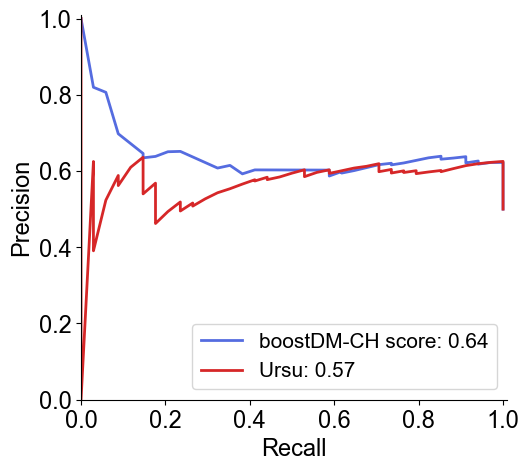

In [40]:
import matplotlib as mpl

def config_params(font_size=12):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    
config_params(font_size=17)
fig, ax = plt.subplots(figsize=(5.5,5))

auc_score_bdm, precision_bdm, recall_bdm, probs_bed = plot_prc(validation_set_predictions, 'boostDM_score', ax=ax, color='#556CE0', lw=2, alpha=1)
auc_score, precision, recall, probs = plot_prc(validation_set_predictions, 'Ursu', ax=ax, color='#d62728', lw=2, alpha=1)
validation_set_predictions['prob_TP53'] = probs

plt.legend(labels=[f'boostDM-CH score: {auc_score_bdm:.2}',\
                   f'Ursu: {auc_score:.2}'], fontsize=15, loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.show()

In [42]:
### Import rule-based deffinition of CH

import sys
sys.path.append("../../../Paper_data/Expert_curated_rules/")
from CH_harvard import niroula_CH
from CH_harvard import bick_CH
from CH_harvard import WHO_CH

### Define classification metric scores

def get_mcc(tp, tn, fp, fn):
    
    try:
        return (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        return None

def get_acc(tp, tn, fp, fn):
    
    try:
        return (tp+tn) / (tp+tn+fp+fn)
    except:
        return None


def get_precision(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fp)
    except:
        return None

    
def get_recall(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fn)
    except:
        return None

    
def get_npv(tp, tn, fp, fn):
    
    try:
        return tn / (tn + fn)
    except:
        return None


def get_f1(tp, tn, fp, fn):
    
    try:
        return tp / (tp + 0.5 * (fp + fn))
    except:
        return None


def get_fbeta(tp, tn, fp, fn, beta=0.5):
    
    """
    beta is chosen such that recall is considered 
    beta times as important as precision
    """
    
    p = 1 + beta ** 2
    
    try:
        return (p * tp) / ((p * tp) + (p - 1) * fn + fp)
    except:
        return None

def quality_statistic(data, method, statistic='Fscore50'):

    ## Define tp, tn, fp, fn
    tp = len(data[(data['Set']==1) & (data[method]==1)])
    tn = len(data[(data['Set']==0) & (data[method]==0)])
    fp = len(data[(data['Set']==0) & (data[method]==1)])
    fn = len(data[(data['Set']==1) & (data[method]==0)])

    ## Calculate quality statistics
    if statistic=='Fscore50':
        return get_fbeta(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='Accuracy':
        return get_acc(tp, tn, fp, fn)
    if statistic=='Precision':
        return get_precision(tp, tn, fp, fn)
    if statistic=='Recall':
        return get_recall(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='MCC':
        return get_mcc(tp, tn, fp, fn)
    if statistic=='NPV':
        return get_npv(tp, tn, fp, fn)

In [43]:
validation_set_predictions[validation_set_predictions['prob_TP53']>=0.5]['Ursu'].min()

216.5178149

In [44]:
validation_set_predictions[validation_set_predictions['prob_TP53']<0.5]['Ursu'].max()

215.0810535

In [45]:
validation_set_predictions['cat_Ursu'] = validation_set_predictions['prob_TP53'].apply(lambda x:1 if x >=0.5 else 0)
validation_set_predictions

,gene,chr,pos,ref,alt,aachange_x,Set,Prot_pos,aachange_y,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO,iteration,Ursu,prob_TP53,cat_Ursu
0,TP53,17,7674250,C,A,C238F,1,238,C238F,1,0,0,0,0.993032,1,1.0,0.0,0.0,1.0,0,305.883324,0.655453,1
1,TP53,17,7674241,G,C,S241C,1,241,S241C,1,0,0,0,0.958831,1,1.0,1.0,1.0,1.0,0,159.145010,0.398420,0
2,TP53,17,7675139,C,T,R158H,1,158,R158H,1,0,0,0,0.981253,1,1.0,1.0,1.0,1.0,0,145.812631,0.375681,0
3,TP53,17,7674893,C,T,R213Q,1,213,R213Q,1,0,0,0,0.966070,1,1.0,1.0,1.0,1.0,0,110.153982,0.317706,0
4,TP53,17,7674250,C,T,C238Y,1,238,C238Y,1,0,0,0,0.993032,1,1.0,1.0,1.0,1.0,0,283.780573,0.618730,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,TP53,17,7674883,C,T,V216V,0,216,V216V,0,0,0,1,0.000485,0,0.0,0.0,0.0,0.0,49,39.491832,0.218840,0
3396,TP53,17,7676121,G,A,A83V,0,83,A83V,1,0,0,0,0.000277,0,1.0,0.0,0.0,0.0,49,27.132006,0.204026,0
3397,TP53,17,7675143,C,A,V157F,0,157,V157F,1,0,0,0,0.394774,0,1.0,1.0,1.0,1.0,49,233.513166,0.530638,1
3398,TP53,17,7674865,C,T,P222P,0,222,P222P,0,0,0,1,0.000710,0,0.0,0.0,0.0,0.0,49,29.575529,0.206895,0


In [46]:
#Analysis

eval_boostdm = []
eval_experimental = []

#make same random
for i in range(0,50):
    gene_crossval_harv_i = validation_set_predictions[validation_set_predictions['iteration']==i]
    driv1 = gene_crossval_harv_i[gene_crossval_harv_i['Set']==1]
    driv0 = gene_crossval_harv_i[gene_crossval_harv_i['Set']==0]
    if len(driv1) > len(driv0):
        driv1 = driv1.sample(n=len(driv0), random_state=42)
    elif len(driv1) < len(driv0):
        driv0 = driv0.sample(n=len(driv1), random_state=42)
    gene_crossval_harv_equal_i = pd.concat([driv1, driv0])
    
    ## Calculate all statistics for each method
    for method in ['boostDM_class', 'cat_Ursu']:
        statistics = []
        for statistic in ['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']: 
            # Calculate statistic
            statistics.append(quality_statistic(gene_crossval_harv_equal_i, method=method, statistic=statistic))
        if method == 'boostDM_class': eval_boostdm.append(statistics)
        elif method == 'cat_Ursu': eval_experimental.append(statistics)


In [47]:
### Create summary dataframe with means

results_dataframe_12 = pd.DataFrame({'Statistic': pd.Series(['$F_{50}$', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']),
                'BoostDM': pd.DataFrame(eval_boostdm).mean(),
                'experimental': pd.DataFrame(eval_experimental).mean(),
                'BoostDM_Q1': pd.DataFrame(eval_boostdm).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'BoostDM_Q3': pd.DataFrame(eval_boostdm).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'experimental_Q1': pd.DataFrame(eval_experimental).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'experimental_Q3': pd.DataFrame(eval_experimental).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0]})
results_dataframe_12

,Statistic,BoostDM,experimental,BoostDM_Q1,BoostDM_Q3,experimental_Q1,experimental_Q3
0,$F_{50}$,0.664561,0.628156,0.651261,0.682859,0.606796,0.644330
1,F1,0.739533,0.664068,0.729412,0.753820,0.649351,0.675676
2,Accuracy,0.677941,0.626765,0.661765,0.702206,0.602941,0.647059
3,Precision,0.622569,0.606482,0.607843,0.642538,0.581395,0.625000
4,Recall,0.911765,0.735294,0.911765,0.911765,0.735294,0.735294
5,NPV,0.831350,0.658802,0.823529,0.848026,0.640000,0.678571


In [48]:
plot_data = results_dataframe_12.iloc[[0, 3, 4],0:3].reset_index(drop=True)
error_data = results_dataframe_12.iloc[[0, 3, 4],].reset_index(drop=True)

error_data

,Statistic,BoostDM,experimental,BoostDM_Q1,BoostDM_Q3,experimental_Q1,experimental_Q3
0,$F_{50}$,0.664561,0.628156,0.651261,0.682859,0.606796,0.644330
1,Precision,0.622569,0.606482,0.607843,0.642538,0.581395,0.625000
2,Recall,0.911765,0.735294,0.911765,0.911765,0.735294,0.735294


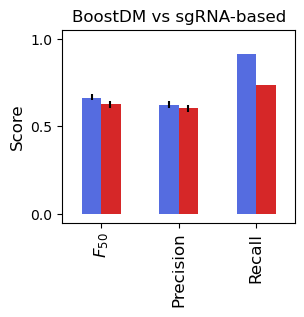

In [50]:
mpl.style.use('default')
plot_data[plot_data['Statistic'].isin([r"$F_{50}$", 'Precision', 'Recall'])].plot.bar(x='Statistic', figsize=(3,2.5), color=['#556CE0', '#d62728'])

#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[abs(row.BoostDM-row.BoostDM_Q1)], [abs(row.BoostDM_Q3-row.BoostDM)]]
    plt.errorbar(idx-0.12,row.BoostDM, yerr=ci, fmt=' ', ecolor = 'k')
#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.experimental-row.experimental_Q1], [row.experimental_Q3-row.experimental]]
    plt.errorbar(idx+0.12,row.experimental, yerr=ci, fmt=' ', ecolor = 'k')

plt.title('BoostDM vs sgRNA-based', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')

plt.xticks(np.arange(3), [r"$F_{50}$", 'Precision', 'Recall'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
plt.show()